In [1]:
import sys

sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms
from torchinfo import summary
from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from MBNV3 import MBNV3Creator
from config import comet_token, project_name, workspace
from comet_ml import Experiment

#setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": None,
    "module_alias": "SE",
    "data_path": "/Users/leo/Desktop/Thesis/data/celebs_20/",
    "batch_size": 16,
    "img_size": 224,
    "num_classes": 20,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/mbnv3-faces-50-scratch/dd9e2ae698994509b77fa0d6f25c9086



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


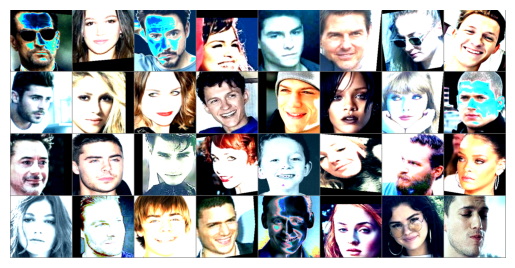

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

SE layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
SE inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
Weights initialized for SE inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11] as well as the last layer.


In [7]:
summary(model, input_size=(1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 224, 224]     [1, 20]              --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

  0%|          | 0/65 [00:00<?, ?it/s]/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)
100%|██████████| 9/9 [00:01<00:00,  5.01it/s]


Epoch: 01 | Epoch Time: 0.0m 31s
	Train Loss: 3.003 | Train Acc: 6.78%
	 Val. Loss: 2.999 |  Val. Acc: 5.00%
Best Accuracy Achieved: 5.00% on epoch 01


 78%|███████▊  | 7/9 [00:01<00:00,  6.18it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/6e932ac7a0f84f4ab29db7d37c81e01a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.0070936596393585205
COMET INFO:     test_accuracy   : 0.8899999856948853
COMET INFO:     test_loss       : 0.3416920202970505
COMET INFO:     train_acc [50]  : (0.2610526382923126, 0.9908772110939026)
COMET INFO:     train_loss [50] : (0.032819434300293784, 3.0802719934363116)
COMET INFO:     val_acc [50]    : (0.10545454919338226, 0.9163636565208435)
COMET INFO:     val_loss [50]   : (0.34274567520079224, 4.108187457214703)
COMET INFO:   Parameters:
COMET INFO:     backbone        : <function mobilenet_v3_small at 0x176534040>
COMET INFO:     batch_size      : 16
COMET INFO:     data_path       

Test loss: 0.342.. 
Test accuracy: 0.890
Test Time: 0.0m 1s 418ms


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


(0.3416920202970505, tensor(0.8900, device='mps:0'))